In [1]:
# Deep conditional Gan with mnist Dataset
# In this notebook, we create a Conditional Gan with pytorch lightning
# The purpose of a a conditional Gan is to obtain a generative neural network
# generating new images of one specific class (the condition)

In [2]:
!pip install pytorch_lightning

     |████████████████████████████████| 527 kB 5.3 MB/s 
     |████████████████████████████████| 829 kB 42.0 MB/s 
     |████████████████████████████████| 133 kB 43.0 MB/s 
     |████████████████████████████████| 596 kB 33.3 MB/s 
     |████████████████████████████████| 952 kB 38.1 MB/s 
     |████████████████████████████████| 397 kB 32.6 MB/s 
     |████████████████████████████████| 1.1 MB 40.6 MB/s 
     |████████████████████████████████| 271 kB 45.2 MB/s 
     |████████████████████████████████| 144 kB 36.8 MB/s 
     |████████████████████████████████| 94 kB 1.7 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=9f3309601415e25d363800701e1a8682eb6c0b8eddcf129a23d1a97b7e6f0c7d
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

In [44]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import random
import numpy as np
import torchvision
from torch.utils.data import DataLoader, dataloader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import Callback
from torch.autograd import Variable
from torchvision.datasets import MNIST
import torchmetrics
import time
import os
import copy

In [34]:
%matplotlib inline

In [ ]:
# We define a generator with only linear layers
# the inputs of the generator are a noise and the label of
# the desired class

In [17]:
class Generateur(pl.LightningModule):
    def __init__(self, inp_shape, lab_shape, out_shape):
        super().__init__()
        self.save_hyperparameters()
        self.inp_shape = inp_shape
        self.lab_shape = lab_shape
        self.out_shape = out_shape

        self.label = nn.Embedding(lab_shape, lab_shape)
        self.fc1 = nn.Linear(np.prod(inp_shape) + lab_shape, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, np.prod(out_shape))

    def forward(self, batch):
        (x, y) = batch
        x = torch.cat([x, self.label(y)], dim=-1)   
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        return x

In [ ]:
# We create a discriminator model with only linear layers,
# the inputs are the image and the label associated

In [23]:

class Discriminateur(pl.LightningModule):
    def __init__(self, img_shape, lab_shape):
        super().__init__()
        self.save_hyperparameters()
        self.img_shape = img_shape
        self.lab_shape = lab_shape

        self.label = nn.Embedding(lab_shape, lab_shape)
        self.fc1 = nn.Linear(np.prod(img_shape) + lab_shape, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def forward(self, batch):
        (x, y) = batch
        x = x.view(x.size(0), -1)
        x = torch.cat((x, self.label(y)), dim=1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
# The gan model is composed with a generator and a discriminator
# we save the loss values in a dict, history (logs are possible with logger)

In [24]:
class GAN(pl.LightningModule):
    def __init__(self, inp_shape, nb_classes, img_shape, learning_rate=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.inp_shape = inp_shape
        self.nb_classes = nb_classes
        self.img_shape = img_shape

        self.learning_rate = learning_rate
        self.generateur = Generateur(inp_shape, nb_classes, img_shape)
        self.discriminateur = Discriminateur(img_shape, nb_classes)

        self.criterion = nn.BCELoss() 
        self.accuracy_gen = torchmetrics.MeanSquaredError() 
        self.accuracy_dis = torchmetrics.MeanSquaredError()
        self.precisionx = torchmetrics.Precision(average='micro')

        self.history = {}
        for out in ['loss', 'dis_loss', 'dis_true_loss', 'gen_loss']:
          self.history[out] = []
    

    def forward(self, x):
        return x

    def training_step(self, batch, batch_idx, optimizer_idx):
        true_img, true_lab = batch

        valid = torch.ones(true_img.size(0), 1)
        self.valid = valid.type_as(true_img)

        fake = torch.zeros(true_img.size(0), 1)
        self.fake = fake.type_as(true_img)

        if optimizer_idx == 0:
            # generate fake
            fake_noise = torch.randn(true_img.shape[0], np.prod(self.inp_shape))
            fake_noise = fake_noise.type_as(true_img)
            gen_out_fake = self.generateur((fake_noise, true_lab))
            dis_out_fake = self.discriminateur((gen_out_fake, true_lab))
            generateur_loss = self.criterion(dis_out_fake, self.valid)  # the generator try to fool the discriminator
            return {'loss':generateur_loss, 'gen_loss':generateur_loss}

        elif optimizer_idx == 1:
            dis_out_true = self.discriminateur((true_img, true_lab))
            dis_true_loss = self.criterion(dis_out_true, self.valid)

            fake_noise = torch.randn(true_img.shape[0], np.prod(self.inp_shape))
            fake_noise = fake_noise.type_as(true_img)
            gen_out_fake = self.generateur((fake_noise, true_lab))
            dis_out_fake = self.discriminateur((gen_out_fake.detach(), true_lab))
            dis_loss = self.criterion(dis_out_fake, self.fake)
            discriminateur_loss = (dis_true_loss + dis_loss) / 2
            return {'loss':discriminateur_loss, 'dis_loss': dis_loss, 'dis_true_loss': dis_true_loss}

    def training_epoch_end(self, training_step_outputs):
      for i, outs in enumerate([['gen_loss'], ['dis_loss', 'dis_true_loss']]):
        for out in outs:
          val = [x[out] for x in training_step_outputs[i]]
          avg = torch.mean(torch.FloatTensor(val))
          self.logger.experiment.add_scalars("losses", {out: avg}, global_step=self.current_epoch)
          self.history[out] += [avg.numpy()]


    def configure_optimizers(self):
        generateur_opt = torch.optim.Adam(self.generateur.parameters(), lr=self.learning_rate, 
                                          betas=(0.5, 0.999))
        discriminateur_opt = torch.optim.Adam(self.discriminateur.parameters(), lr=self.learning_rate,
                                              betas=(0.5, 0.999))
        return [generateur_opt, discriminateur_opt]

In [ ]:
# We train the GAN model: the number of epochs is important, 100 and
# the batch size is 1024
# we use the train part of mnist dataset

In [45]:
# train
inp_shape = [118]
nb_classes = 10
img_shape = [28, 28]
net = GAN(inp_shape, nb_classes, img_shape, learning_rate=0.0003)

batch_size = 1024
train_ds = MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)


# Initialize a trainer
trainer = pl.Trainer(
    gpus=1,
    max_epochs=100
)

# Train the model ⚡
trainer.fit(net, train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | generateur     | Generateur       | 2.0 M 
1 | discriminateur | Discriminateur   | 1.5 M 
2 | criterion      | BCELoss          | 0     
3 | accuracy_gen   | MeanSquaredError | 0     
4 | accuracy_dis   | MeanSquaredError | 0     
5 | precisionx     | Precision        | 0     
----------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.824    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'gen_loss'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'dis_true_loss', 'dis_loss'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


In [ ]:
# we plot the loss curves

[]


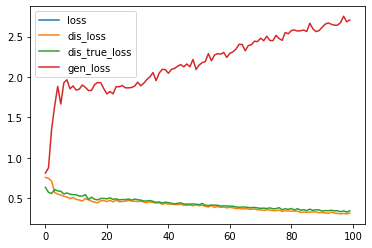

In [46]:
print(net.history['loss'])
for k in net.history:
  plt.plot(net.history[k], label=k)
plt.legend()

In [ ]:
# we use the trained generator to generate images for labels 0 to 8

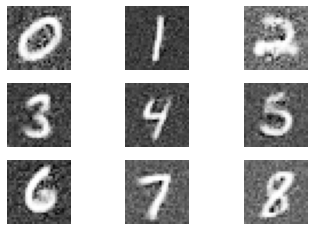

In [47]:
for i in range(9):
    plt.subplot(331 + i)
    fake_noise = torch.randn(size=(1, 118)).float()
    x = torch.from_numpy(np.array([i]))
    img = net.generateur((fake_noise, x))
    img = np.squeeze(img.detach().numpy())
    img = np.reshape(img, (28, 28))
    plt.imshow(img, cmap='gray')
    plt.axis("off")

In [ ]:
# finally, we plot 15 samples generated for each class, from 0 to 9 
# to control the generator 

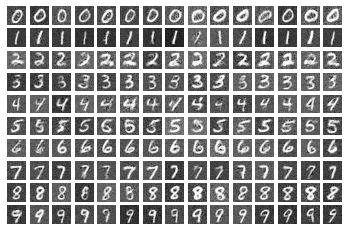

In [51]:
from IPython.core.display import Image
def generate_sample(num=0):
    fake_noise = torch.randn(size=(1, 118)).float()
    x = torch.from_numpy(np.array([num]))
    img = net.generateur((fake_noise, x))
    img = np.squeeze(img.detach().numpy())
    img = np.reshape(img, (28, 28))
    return img

nb_samples = 15
fig, axs = plt.subplots(10, nb_samples)
for i in range(10):
  for j in range(nb_samples):
      img = generate_sample(i)
      axs[i, j].imshow(img, cmap='gray')
      axs[i, j].set_axis_off()